# Networks

## Exploring how billboards and signage affect our digital patterns

#### CDP '24: Mapping Systems, Assignment 03

### Part 1
Using a dataset of billboards and signage, we extract the metadata of the images to geolocate them, then we extract the labeled regions, and run a pre-trained model to extract the labels for them. This gives us a data set of labels to coordinates on the map.

In [2]:
%matplotlib ipympl

import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import geopandas as gpd
import lonboard
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap
import contextily as ctx
import pandas as pd
import seaborn as sns
import numpy as np
import folium
from folium.plugins import MarkerCluster
import h3
import os
from PIL import Image
from PIL.ExifTags import TAGS

In [65]:

def get_image_metadata(image_path):
    image = Image.open(image_path)
    exif = image._getexif()
    metadata = {}
    if exif:
        for tag, value in exif.items():
            tag_name = TAGS.get(tag, tag)
            metadata[tag_name] = value
    return metadata

def extract_lat_long(metadata):
    gps_info = metadata.get('GPSInfo', {})
    if not gps_info:
        return None

    lat = gps_info.get(2)
    lon = gps_info.get(4)
    lat_ref = gps_info.get(1)
    lon_ref = gps_info.get(3)

    if lat and lon and lat_ref and lon_ref:
        lat = float(lat[0]) + float(lat[1]) / 60 + float(lat[2]) / 3600
        lon = float(lon[0]) + float(lon[1]) / 60 + float(lon[2]) / 3600
        
        lat *= -1 if lat_ref != 'N' else 1
        lon *= -1 if lon_ref != 'E' else 1
        
        return Point(lon, lat)
    else:
        return None

def process_images_in_directory(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    results = []
    for image in images:
        image_path = os.path.join(directory, image)
        metadata = get_image_metadata(image_path)
        point = extract_lat_long(metadata)
        if point:
            results.append((image, point))
    return results

# Example usage
directory = '../Data/billboards-signs-and-branding.2022-08-11T185322Z/images'
results = process_images_in_directory(directory)
for image, point in results:
    print(f"Image: {image}, Point: {point}")


Image: WittyWorthlessIrishdraughthorse.jpg, Point: POINT (-118.39898055555557 34.06248055555555)
Image: StudiousMemorableDesertpupfish.jpg, Point: POINT (-118.34420833333333 34.07272777777778)
Image: VainWebbedIchidna.jpg, Point: POINT (-118.34424722222222 34.07607222222222)
Image: MistyroseWornShibainu.jpg, Point: POINT (-118.34884722222222 34.07605277777778)
Image: LikelyGaseousJunco.jpg, Point: POINT (-118.34389444444444 34.06954166666667)
Image: BlaringTallQuetzalcoatlus.jpg, Point: POINT (-118.34369722222222 34.05445833333333)
Image: HungryLivePrairiedog.jpg, Point: POINT (-118.3456361111111 34.076122222222224)
Image: TreasuredPrudentSableantelope.jpg, Point: POINT (-118.34419444444444 34.07602777777778)
Image: NaughtySecondNag.jpg, Point: POINT (-118.34384166666666 34.07390277777778)
Image: TautLimegreenXuanhanosaurus.jpg, Point: POINT (-118.39918611111112 34.062083333333334)
Image: SquigglyAdoredEquestrian.jpg, Point: POINT (-118.39911666666667 34.060874999999996)
Image: PlumpLi

In [66]:
def create_geopandas_dataframe(results):
    data = {
        'Image': [result[0] for result in results],
        'Point': [result[1] for result in results]
    }
    gdf = gpd.GeoDataFrame(data, geometry='Point')
    return gdf

# Example usage
gdf = create_geopandas_dataframe(results)
print(gdf)



                                  Image                        Point
0   WittyWorthlessIrishdraughthorse.jpg  POINT (-118.39898 34.06248)
1    StudiousMemorableDesertpupfish.jpg  POINT (-118.34421 34.07273)
2                 VainWebbedIchidna.jpg  POINT (-118.34425 34.07607)
3             MistyroseWornShibainu.jpg  POINT (-118.34885 34.07605)
4                LikelyGaseousJunco.jpg  POINT (-118.34389 34.06954)
..                                  ...                          ...
92         PowerfulOrdinaryHousefly.jpg  POINT (-118.34404 34.07520)
93        FinishedTruthfulDromedary.jpg  POINT (-118.35306 34.07043)
94      InstructiveLightyellowLarva.jpg  POINT (-118.39920 34.06712)
95           MeagerFilthyQueenconch.jpg  POINT (-118.35143 34.07013)
96           DistantGaseousNematode.jpg  POINT (-118.35342 34.07051)

[97 rows x 2 columns]


In [5]:
gdf.geometry

0     POINT (-118.39898 34.06248)
1     POINT (-118.34421 34.07273)
2     POINT (-118.34425 34.07607)
3     POINT (-118.34885 34.07605)
4     POINT (-118.34389 34.06954)
                 ...             
92    POINT (-118.34404 34.07520)
93    POINT (-118.35306 34.07043)
94    POINT (-118.39920 34.06712)
95    POINT (-118.35143 34.07013)
96    POINT (-118.35342 34.07051)
Name: Point, Length: 97, dtype: geometry

In [ ]:
# Create a map centered around the mean coordinates of the points
mean_lat = gdf.geometry.y.mean()
mean_lon = gdf.geometry.x.mean()
m = folium.Map(location=[mean_lat, mean_lon], tiles="Cartodb Positron", zoom_start=12)

# Add points to the map
marker_cluster = MarkerCluster().add_to(m)
base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/images"
for idx, row in gdf.iterrows():
    image_path = os.path.join(base, row['Image'])
    icon = folium.CustomIcon(image_path, icon_size=(50, 50))
    folium.Marker(location=[row['Point'].y, row['Point'].x], icon=icon).add_to(marker_cluster)

# Display the map
m


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np
import pandas as pd

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

def get_image_labels(image_array):
    x = np.expand_dims(image_array, axis=0)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    labels = decode_predictions(preds, top=3)[0]
    return labels

def extract_region(image_path, coords):
    img = image.load_img(image_path)
    img_array = image.img_to_array(img)
    x_min, y_min, x_max, y_max = coords
    img_height, img_width, _ = img_array.shape
    x_min = max(0, int(x_min * img_width))
    x_max = min(img_width, int(x_max * img_width))
    y_min = max(0, int(y_min * img_height))
    y_max = min(img_height, int(y_max * img_height))
    
    # Check if the region is valid
    if x_min >= x_max or y_min >= y_max:
        return None
    
    region = img_array[y_min:y_max, x_min:x_max]

    # Display the region image (for debugging)
    # plt.imshow(region.astype(np.uint8))
    # plt.axis('off')
    # plt.show()
    # print(image_path)
    
    # Check if the region is not empty
    if region.size == 0:
        return None
    
    region = tf.image.resize(region, (224, 224)).numpy()
    return region

# Paths
base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/images"
annotations_base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/annotations"

# Initialize the 'Labels' column with empty lists
gdf['Labels'] = [[] for _ in range(len(gdf))]

for idx, row in gdf.iterrows():
    image_path = os.path.join(base, row['Image'])
    annotation_path = os.path.join(annotations_base, row['Image'].replace('.jpg', '.csv'))
    
    image_labels = []
    if os.path.exists(annotation_path):
        annotations = pd.read_csv(annotation_path)

        for _, annotation in annotations.iterrows():
            if str(annotation['label']) == 'signage':
                continue
            coords = (annotation['x1'], annotation['y1'], annotation['x2'], annotation['y2'])
            region = extract_region(image_path, coords)
            if region is not None:
                labels = get_image_labels(region)
                image_labels.extend(labels)  # Collect several labels for each region
    gdf.at[idx, 'Labels'] = image_labels


In [48]:
# Convert the 'Labels' column to a format that GeoJSON supports
def convert_labels_to_geojson_format(labels):
    # Discard the first element of the tuple, only include the label, and remove duplicates
    filtered_labels = ', '.join(set([label[1] for label in labels]))
    return filtered_labels

gdf_filtered = gdf.copy()
gdf_filtered['Labels'] = gdf_filtered['Labels'].apply(convert_labels_to_geojson_format)



In [49]:
# Save the GeoDataFrame to a file
output_file = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/processed_annotations.geojson"
gdf_filtered.to_file(output_file, driver='GeoJSON')
print(f"GeoDataFrame saved to {output_file}")


GeoDataFrame saved to /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/processed_annotations.geojson


Interactive map saved to /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/interactive_map.html



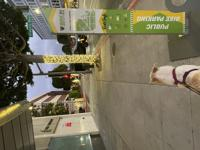
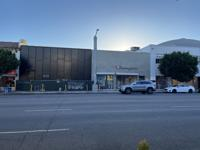
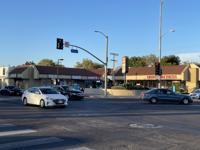
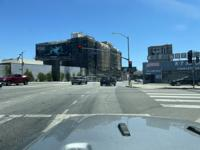
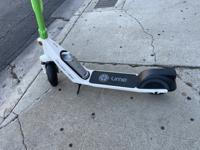
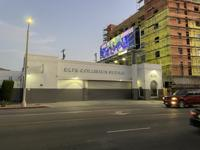
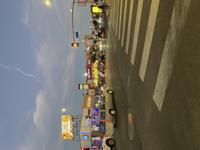
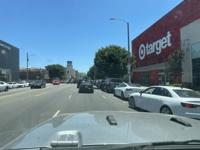
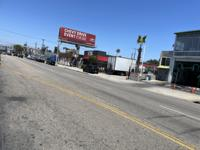
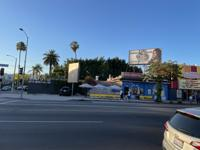
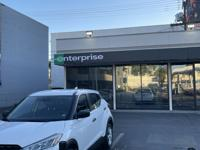
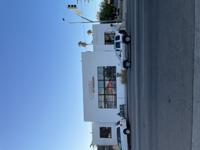
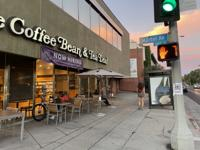
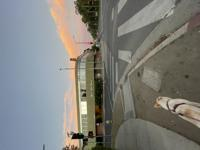
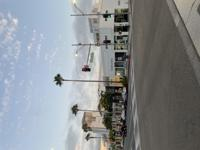
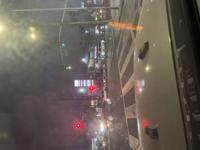
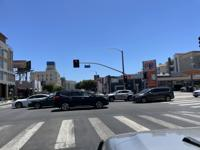
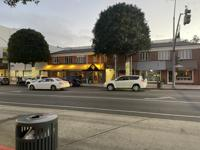
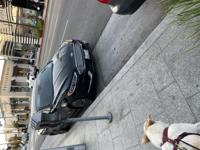
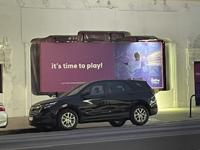
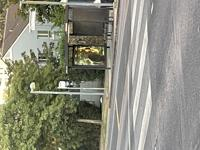
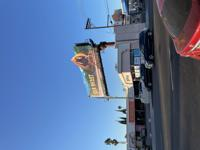
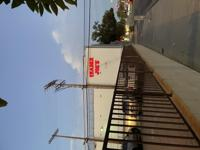
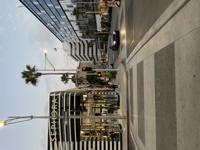
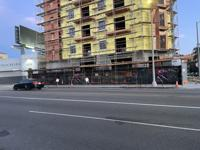
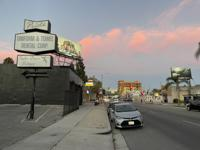
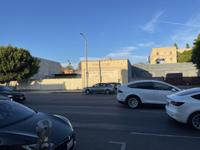
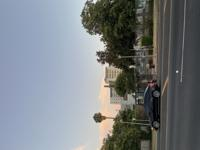
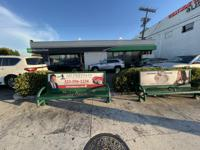
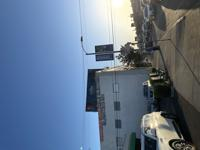
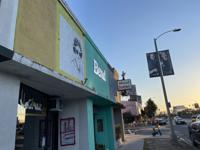
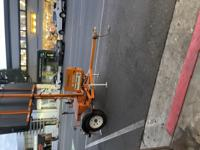
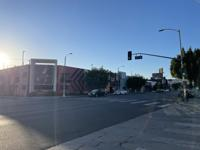
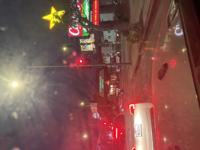
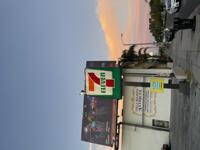
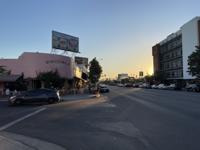
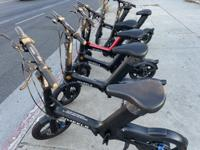
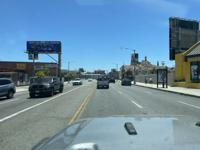
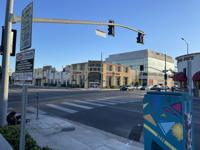
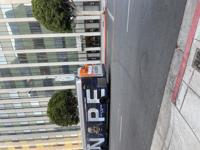
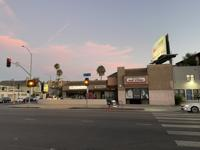
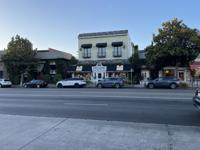
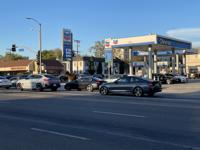
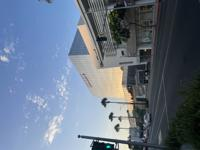
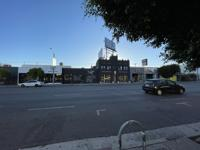
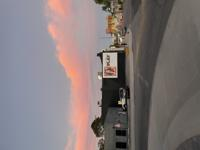
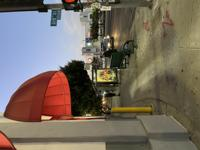
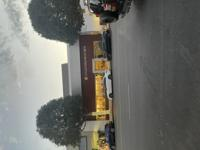
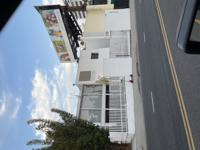
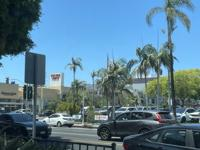
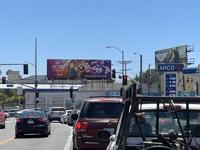
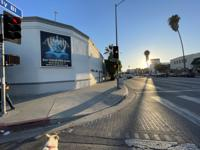
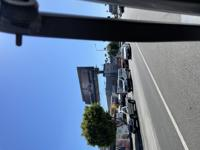
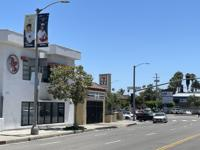
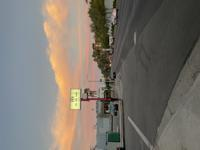
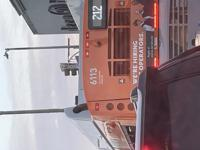
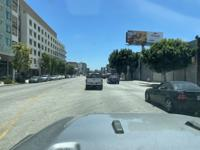
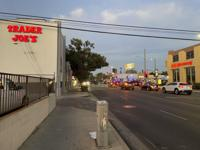
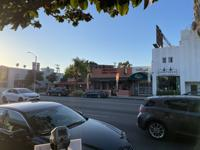
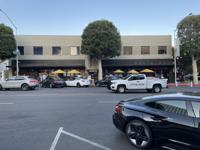
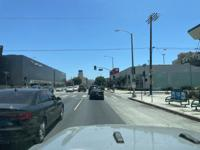
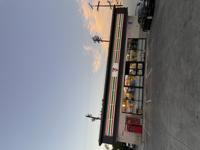
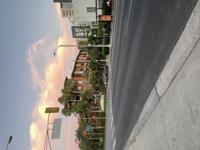
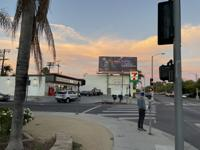

In [64]:
import folium
from folium.plugins import MarkerCluster
from PIL import Image

# Create a map centered around the average coordinates
m = folium.Map(location=[gdf_filtered.geometry.y.mean(), gdf_filtered.geometry.x.mean()], zoom_start=14, tiles="Cartodb Positron")

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/images"
# Add points to the map with hover labels
for idx, row in gdf_filtered.iterrows():
    if row['Labels'] == '':
        continue
    image_path = os.path.join(base, row['Image'])
    small_image_path = os.path.join(base, f"small_{row['Image']}")
    
    # Create a small 100x100 copy of the image
    with Image.open(image_path) as img:
        img.thumbnail((200, 200))
        img.save(small_image_path)
    
    folium.Marker(
        location=[row['Point'].y, row['Point'].x],
        popup=row['Labels'],
        icon=folium.features.CustomIcon(icon_image=small_image_path, icon_size=(100,100))
    ).add_to(marker_cluster)

# Save the map to an HTML file
output_map_file = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/interactive_map.html"
m.save(output_map_file)
print(f"Interactive map saved to {output_map_file}")

# Display the map in the notebook
m
